<a href="https://colab.research.google.com/github/nicoleolivetto/CNN/blob/main/covid_data_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [280]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

In [281]:
covid_ds =pd.read_csv("covid_ds.csv")
covid_ds

,Unnamed: 0,Date,Region_code,Region_name,latitude,longitude,hospitalized_with_symptoms,intensive_care_petients,total_hospitalized_patients,home_isolation,current_positive_cases,change_in_total_positives,new_positive_cases,recovered,deceased,total_cases,tests_performed
0,0,2020-02-24T18:00:00,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,0,5
1,1,2020-02-24T18:00:00,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0,0
2,2,2020-02-24T18:00:00,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,0,1
3,3,2020-02-24T18:00:00,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,0,10
4,4,2020-02-24T18:00:00,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,18,0,18,0,0,18,148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,1717,2020-05-15T17:00:00,19,Sicilia,38.115697,13.362357,198,11,209,1551,1760,-94,8,1351,263,3374,112929
1718,1718,2020-05-15T17:00:00,9,Toscana,43.769231,11.255889,238,67,305,2863,3168,-220,24,5739,976,9883,197365
1719,1719,2020-05-15T17:00:00,10,Umbria,43.106758,12.388247,25,2,27,63,90,-2,2,1259,73,1422,53801
1720,1720,2020-05-15T17:00:00,2,Valle d'Aosta,45.737503,7.320149,37,0,37,40,77,-3,6,953,142,1172,11413


Preprocessing


In [282]:
# Convert 'Date' to datetime
covid_ds['Date'] = pd.to_datetime(covid_ds['Date'])

# Normalize numeric columns
numeric_columns = ['latitude', 'longitude', 'hospitalized_with_symptoms', 'intensive_care_petients',
                    'total_hospitalized_patients', 'home_isolation', 'current_positive_cases',
                    'change_in_total_positives', 'new_positive_cases', 'recovered', 'deceased', 'total_cases',
                    'tests_performed']


scaler = MinMaxScaler()
covid_ds[numeric_columns] = scaler.fit_transform(covid_ds[numeric_columns])

# One-hot encode 'Region_name'
covid_ds = pd.get_dummies(covid_ds, columns=['Region_name'])


In [283]:
print(covid_ds[numeric_columns])

      latitude  longitude  hospitalized_with_symptoms  \
0     0.505213   0.636656                    0.000000   
1     0.301036   0.888741                    0.000000   
2     0.094264   0.971409                    0.000000   
3     0.324903   0.725939                    0.000000   
4     0.760848   0.421230                    0.000828   
...        ...        ...                         ...   
1717  0.000000   0.632876                    0.016395   
1718  0.674353   0.412239                    0.019707   
1719  0.595334   0.530846                    0.002070   
1720  0.909129   0.000000                    0.003064   
1721  0.873035   0.525630                    0.025751   

      intensive_care_petients  total_hospitalized_patients  home_isolation  \
0                    0.000000                     0.000000        0.000000   
1                    0.000000                     0.000000        0.000000   
2                    0.000000                     0.000000        0.000000   
3  

In [284]:
#'selected_regions' contains the region codes you want to learn from (Northern Italy)
selected_regions = [8, 6, 7, 3, 1, 2, 5, 21, 22]  # Replace with the actual region codes you want to select

# Select data for the autoencoder from specified regions
autoencoder_data = covid_ds[covid_ds['Region_code'].isin(selected_regions)]

# Select data for evaluation from other regions
other_regions_data = covid_ds[~covid_ds['Region_code'].isin(selected_regions)]

# Specify the columns relevant for the autoencoder
autoencoder_columns = ['hospitalized_with_symptoms', 'intensive_care_petients', 'total_hospitalized_patients', 'home_isolation', 'current_positive_cases', 'change_in_total_positives', 'new_positive_cases', 'recovered', 'deceased', 'total_cases', 'tests_performed']

# Extract the relevant columns for training and evaluation
train_data = autoencoder_data[autoencoder_columns].values
test_data = other_regions_data[autoencoder_columns].values

# Split the data into training and test sets
train_data, test_data, _, _ = train_test_split(train_data, train_data, test_size=0.2, random_state=42)

# Print the shapes of the training and test sets
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)


Train Data Shape: (590, 11)
Test Data Shape: (148, 11)


In [285]:


# Assuming your input shape is the number of features in your dataset
input_shape = train_data.shape[1]

# Define the autoencoder model
model = models.Sequential()

# Encoder
model.add(layers.InputLayer(input_shape=(input_shape,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))

# Decoder
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(input_shape, activation='sigmoid'))  # Output layer, use 'sigmoid' for non-negative inputs

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Use 'mse' (Mean Squared Error) loss for reconstruction tasks

# Print the model summary
model.summary()


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 64)                768       
                                                                 
 dense_85 (Dense)            (None, 32)                2080      
                                                                 
 dense_86 (Dense)            (None, 64)                2112      
                                                                 
 dense_87 (Dense)            (None, 11)                715       
                                                                 
Total params: 5675 (22.17 KB)
Trainable params: 5675 (22.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [286]:
# Train the model
model.fit(train_data, train_data, epochs=100, batch_size=512, validation_data=(test_data, test_data))


Epoch 1/100
2/2 [==============================] - 1s 158ms/step - loss: 0.1741 - val_loss: 0.1715
Epoch 2/100
2/2 [==============================] - 0s 28ms/step - loss: 0.1694 - val_loss: 0.1669
Epoch 3/100
2/2 [==============================] - 0s 28ms/step - loss: 0.1649 - val_loss: 0.1623
Epoch 4/100
2/2 [==============================] - 0s 29ms/step - loss: 0.1605 - val_loss: 0.1579
Epoch 5/100
2/2 [==============================] - 0s 28ms/step - loss: 0.1562 - val_loss: 0.1533
Epoch 6/100
2/2 [==============================] - 0s 28ms/step - loss: 0.1518 - val_loss: 0.1484
Epoch 7/100
2/2 [==============================] - 0s 28ms/step - loss: 0.1471 - val_loss: 0.1432
Epoch 8/100
2/2 [==============================] - 0s 28ms/step - loss: 0.1421 - val_loss: 0.1377
Epoch 9/100
2/2 [==============================] - 0s 28ms/step - loss: 0.1369 - val_loss: 0.1318
Epoch 10/100
2/2 [==============================] - 0s 29ms/step - loss: 0.1312 - val_loss: 0.1254
Epoch 11/100
2/2 [

In [287]:
# Predict on test data
reconstructed_data = model.predict(test_data)

5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


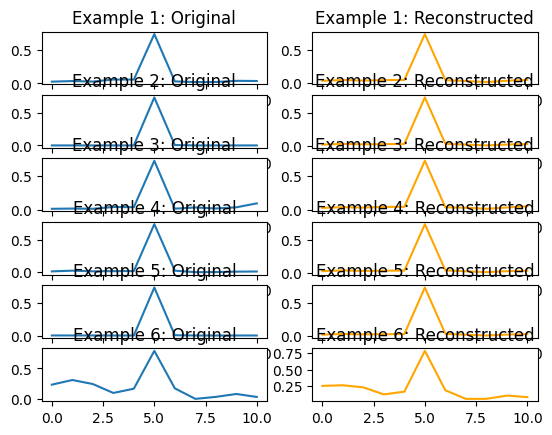

In [288]:
import matplotlib.pyplot as plt

# Predict on test data
reconstructed_data = model.predict(test_data)

# Choose a few random examples for visualization
num_examples = 6
examples_indices = np.random.choice(len(test_data), num_examples, replace=False)

# Plot original and reconstructed data
for i, example_index in enumerate(examples_indices, 1):
    plt.subplot(num_examples, 2, 2 * i - 1)
    plt.plot(test_data[example_index], label='Original')
    plt.title(f'Example {i}: Original')
    #plt.legend()

    plt.subplot(num_examples, 2, 2 * i)
    plt.plot(reconstructed_data[example_index], label='Reconstructed', color='orange')
    plt.title(f'Example {i}: Reconstructed')
    #plt.legend()

plt.show()


In [289]:
print("Shapes before denormalization:")
print("reconstructed_data shape:", reconstructed_data.shape)
print("numeric_cols_mask shape:", numeric_cols_mask.shape)

# Identify numerical columns using boolean indexing
numeric_cols_mask = np.isin(range(reconstructed_data.shape[1]), numeric_cols_indices)

print("Shapes after denormalization:")
print("reconstructed_data_original_scale shape:", reconstructed_data_original_scale.shape)
print("numeric_cols_mask shape:", numeric_cols_mask.shape)



Shapes before denormalization:
reconstructed_data shape: (148, 11)
numeric_cols_mask shape: (11,)
Shapes after denormalization:
reconstructed_data_original_scale shape: (148, 11)
numeric_cols_mask shape: (11,)


In [290]:
print(test_data)

[[8.47064668e-02 1.13685735e-01 8.85354142e-02 ... 2.14781649e-02
  3.20498342e-02 1.41786503e-02]
 [7.53498385e-03 1.88269370e-02 8.77851140e-03 ... 3.63376809e-03
  7.46561419e-03 2.87424715e-03]
 [4.74455577e-02 8.76176684e-02 5.20708283e-02 ... 7.72175719e-03
  1.45151512e-02 6.89310599e-03]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.99852836e-05]
 [1.14597996e-01 9.84793628e-02 1.14045618e-01 ... 2.52092661e-01
  3.20129816e-01 4.34549105e-01]
 [8.61141012e-03 1.52063722e-02 9.37875150e-03 ... 1.94666148e-03
  4.68384075e-03 9.00791236e-03]]


In [291]:
print(reconstructed_data)

[[0.05456923 0.06972539 0.05544576 ... 0.01604747 0.0385425  0.04502606]
 [0.02261761 0.03359919 0.02616848 ... 0.00790776 0.02263962 0.0302681 ]
 [0.03699158 0.05098233 0.03963898 ... 0.01093077 0.02847238 0.03442195]
 ...
 [0.02021392 0.03064296 0.02395615 ... 0.00717193 0.02104177 0.02860757]
 [0.12194151 0.10265549 0.13869508 ... 0.20274487 0.3072181  0.5358609 ]
 [0.02187996 0.03263804 0.02556707 ... 0.00778266 0.02234896 0.03020725]]
